https://projet.liris.cnrs.fr/ccc/ccc2011/doku.php?id=rules

In [1]:
import re

import xml.etree.ElementTree

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Reading and cleaning data

In [2]:
e = xml.etree.ElementTree.parse('recipeBaseCompulsory_clean.xml').getroot()

recipe_ingredients = []
recipe_title = []

for atype in e.findall('RECIPE'):
    ingredients = []
    
    recipe_title.append(atype.find('TI').text)
    
    for i in atype.findall('IN'):
        try:
            ingredients.append(i.text)
        except Exception:
            pass
    
    recipe_ingredients.append(ingredients)

In [3]:
tokenizer = RegexpTokenizer(r'\w+')
porter = PorterStemmer()
stop_words = stopwords.words("english") 
stop_words.extend(['ounce', 'skinless', 'boneless', 'halves', 'cold', 'sized',
                   'cooked', 'unseasoned', 'colored', 'light', 'medium', 'thinly',
                   'coarsely', 'crushed', 'whole', 'recipe', 'pitted', 'bing'])

recipe_ingredients_clean = []
recipe_title_clean = []

for rec_tit in recipe_title:
    t = rec_tit.lower()
    words = tokenizer.tokenize(t)

    recipe_title_clean.append(' '.join([word for word in words 
                                       if word not in stop_words
                                       and not word.isdigit() 
                                       and len(word) > 3]))

recipe_title_clean = list(filter(None, recipe_title_clean))

    
for rec_ing in recipe_ingredients:
    ingredients_clean = []
    
    for ing in rec_ing:
        t = ing.lower()
        t = re.sub("[\(\[].*?[\)\]]", "", t) # Remove brackets
        t = t.split(',')[0]
        t = t.split(';')[0]
        t = t.split(' or ')[0]

        words = tokenizer.tokenize(t)

        ingredients_clean.append(' '.join([word for word in words 
                                           if word not in stop_words
                                           and not word.isdigit() 
                                           and len(word) > 3]))
        
    ingredients_clean = list(filter(None, ingredients_clean))
    recipe_ingredients_clean.append(ingredients_clean)

In [36]:
pd.DataFrame(recipe_ingredients_clean).to_csv('datasets/recipe_ingredients_transactions.csv', sep=';', 
                                              header=False, index=False, na_rep=None)

<br>
# Useful functions

---
```R
itemFrequencyPlot(Adult, support = 0.1, cex.names=0.8, topN = NULL)
```
---

In [4]:
def item_frequency_plot(df_transactions, support=0, top_n=None, ticks_fontsize=12):
    frequent_itemsets = apriori(df_transactions, 
                                min_support=support, 
                                use_colnames=True)
    
    frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
    
    if top_n:
        frequent_itemsets = frequent_itemsets.head(top_n)
        
    
    fig = frequent_itemsets.plot('itemsets',
                                 'support',
                                 kind='bar',
                                 fontsize=ticks_fontsize,
                                 legend=False,
                                 title='Item Frequency', 
                                 colormap='GnBu_r')
    fig.set_ylabel("Support", fontsize=12)
    fig.set_xlabel("Itemsets", fontsize=12)

Package **arulesViz**

---
```R
plot(rules2, measure=c("support","lift"), shading="confidence") 
```
---

In [5]:
def assoc_rules_plot(assoc_rules, measure=('support', 'confidence'), shading=None):
    X = assoc_rules[measure[0]]
    y = assoc_rules[measure[1]]
    
    c = 'r'
    cmap = None
    if shading:
        c = assoc_rules[shading]
        cmap = 'Reds'
    
    plt.scatter(X, y, c=c, cmap=cmap)
    plt.xlabel(measure[0])
    plt.ylabel(measure[1])
    
    if shading:
        col_bar = plt.colorbar()
        col_bar.ax.set_title(shading)

<br>
# Association Rules

Una regla de asociación busca regularidades en los datos. Intenta asociar datos, objetos, eventos... que aparecen juntos para buscar patrones, asociaciones o correlaciones.

El recuento ($\sigma$) es el número de veces que aparece un itemset en el dataset.

El soporte de la regla ($s$) es la probabilidad de que una transacción contenga a $X$ y a $Y$:

$$ s(X \rightarrow Y) = \frac{\sigma(X, Y)}{T} $$

La confianza de la regla ($c$) es la probabilidad de que una transacción que contenga a $X$ también contenga a $Y$:

$$ c(X \rightarrow Y) = \frac{\sigma(X, Y)}{\sigma(X)} $$

El algoritmo Apriori sirve para reducir los candidatos a itemset frecuente. Se basa en la pripiedad de que si un itemset no es frecuente, tampoco lo serán sus supersets; mientras que si un itemset es frecuente, también lo serán sus subconjuntos.

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/


---
```R
fish_rules = apriori(fish_trans, parameter=list(support=0.03, confidence=0.01,
                                                minlen=1, maxlen=1000,
                                                target='frequent itemsets'))
```
---

---
```R
fish_rules = apriori(fish_trans, parameter=list(support=0.03, confidence=0,
                                                minlen=1, maxlen=1000,
                                                target='rules'))
```
---

<br>
## All dataset

In [6]:
te = TransactionEncoder()
te_ary = te.fit(recipe_ingredients_clean).transform(recipe_ingredients_clean)

df_transactions = pd.DataFrame(te_ary, columns=te.columns_)
df_transactions.head()

,accent,acorn squash,across bone inch thick,acrylic paints,active dried yeast,active yeast,active yeast star,active yeast warm water,acuavit,additional butter,...,zampone sausage,zest,zinfandel reduction sauce,zinfandel wine,ziti,zucchini,zucchini pieces,zucchini sliced rings,zucchinis,zuchinni
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


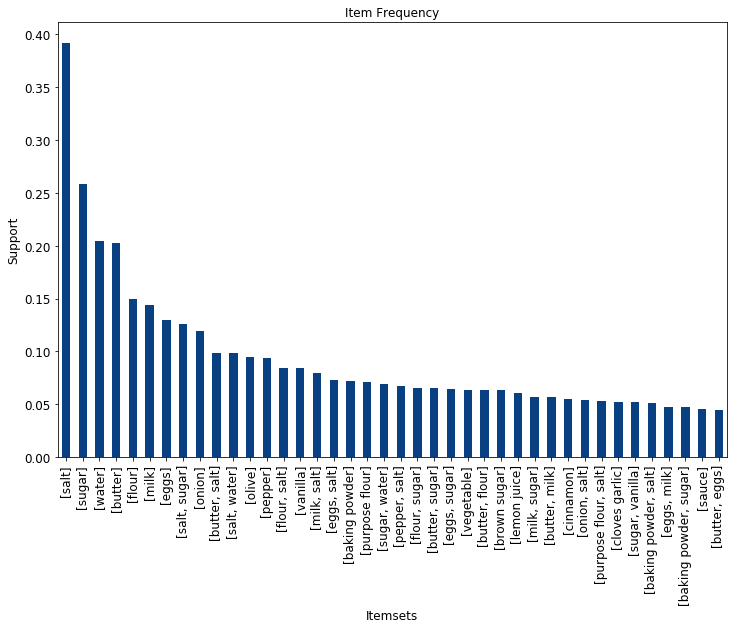

In [7]:
item_frequency_plot(df_transactions, support=0.005, top_n=40)

In [8]:
frequent_itemsets = apriori(df_transactions, min_support=0.005, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)

rules["antecedant_len"] = rules["antecedants"].apply(lambda x: len(x))
print('Number of rules with min_support = 0.005:', len(rules))

Number of rules with min_support = 0.005: 5212


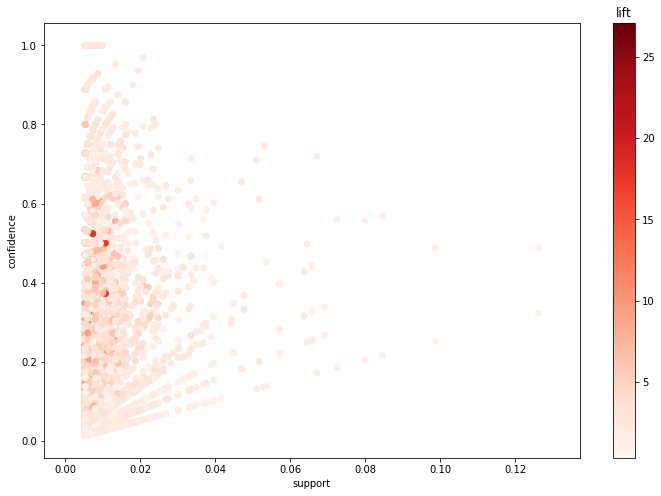

In [9]:
assoc_rules_plot(rules, shading='lift')

<br>
## With min_support and confidence limit

In [30]:
frequent_itemsets = apriori(df_transactions, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules.sort_values(['support', 'confidence'], ascending=False).head(50)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
114,(pepper),(salt),0.093351,0.391538,0.067159,0.719424,1.837432,0.030609,2.168621
106,(purpose flour),(salt),0.071189,0.391538,0.053056,0.745283,1.903476,0.025183,2.388777
64,(vanilla),(sugar),0.084621,0.258563,0.051713,0.611111,2.363492,0.029833,1.906553
6,(baking powder),(salt),0.071860,0.391538,0.051041,0.710280,1.814078,0.022905,2.100175
56,(baking powder),(sugar),0.071860,0.258563,0.047011,0.654206,2.530161,0.028431,2.144156
1,"(butter, sugar)",(salt),0.065816,0.391538,0.039624,0.602041,1.537631,0.013854,1.528956
91,"(milk, sugar)",(salt),0.057085,0.391538,0.034923,0.611765,1.562466,0.012572,1.567251
34,"(sugar, baking powder)",(salt),0.047011,0.391538,0.033580,0.714286,1.824308,0.015173,2.129617
35,"(baking powder, salt)",(sugar),0.051041,0.258563,0.033580,0.657895,2.544429,0.020382,2.167278
104,"(milk, eggs)",(salt),0.047683,0.391538,0.030222,0.633803,1.618752,0.011552,1.661569


<br>
## Fish

In [31]:
fish_words = ['fish', 'seafood', 'snapper', 'tuna', 'bluefish', 
              'shark', 'croaker', 'flounder', 'trout']

fish_recipes_idx = [i for i, e in enumerate(recipe_title_clean) for x in fish_words if x in e]
fish_recipes_ingredients = list(np.asarray(recipe_ingredients_clean)[fish_recipes_idx])

print('Number of recipes with fish:', len(fish_recipes_ingredients))

Number of recipes with fish: 46


In [37]:
pd.DataFrame(fish_recipes_ingredients).to_csv('datasets/fish_recipes_transactions.csv', sep=';', 
                                              header=False, index=False, na_rep=None)

In [15]:
te = TransactionEncoder()
te_ary = te.fit_transform(fish_recipes_ingredients)

df_fish_transactions = pd.DataFrame(te_ary, columns=te.columns_)

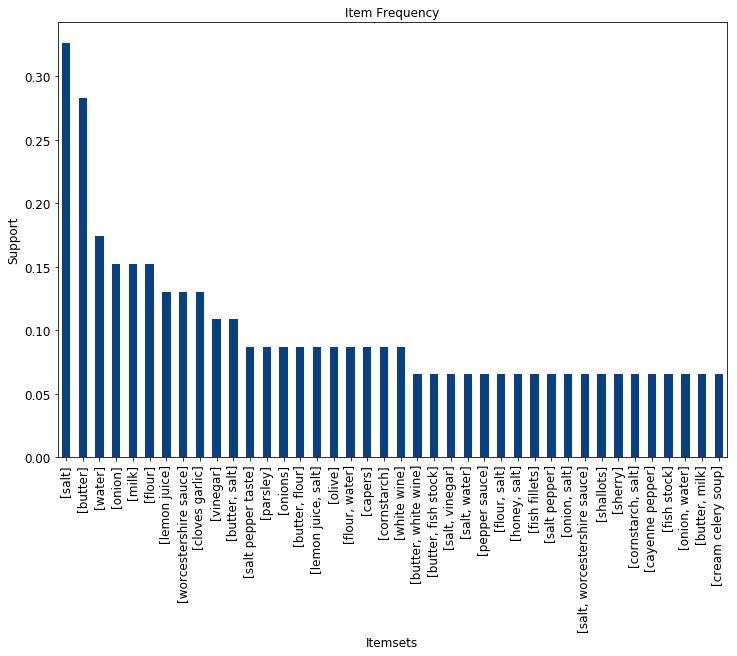

In [32]:
item_frequency_plot(df_fish_transactions, support=0.03, top_n=40)

In [34]:
fish_frequent_itemsets = apriori(df_fish_transactions, min_support=0.03, use_colnames=True)
fish_rules = association_rules(fish_frequent_itemsets, metric="confidence", min_threshold=0)

fish_rules.sort_values(['support', 'confidence'], ascending=False).head(50)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2388,(butter),(salt),0.282609,0.326087,0.108696,0.384615,1.179487,0.016541,1.095109
2389,(salt),(butter),0.326087,0.282609,0.108696,0.333333,1.179487,0.016541,1.076087
4128,(lemon juice),(salt),0.130435,0.326087,0.086957,0.666667,2.044444,0.044423,2.021739
565,(flour),(butter),0.152174,0.282609,0.086957,0.571429,2.021978,0.043951,1.673913
5008,(flour),(water),0.152174,0.173913,0.086957,0.571429,3.285714,0.060491,1.927536
5009,(water),(flour),0.173913,0.152174,0.086957,0.500000,3.285714,0.060491,1.695652
564,(butter),(flour),0.282609,0.152174,0.086957,0.307692,2.021978,0.043951,1.224638
4129,(salt),(lemon juice),0.326087,0.130435,0.086957,0.266667,2.044444,0.044423,1.185771
259,(leaf),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf
1047,(fish stock),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf


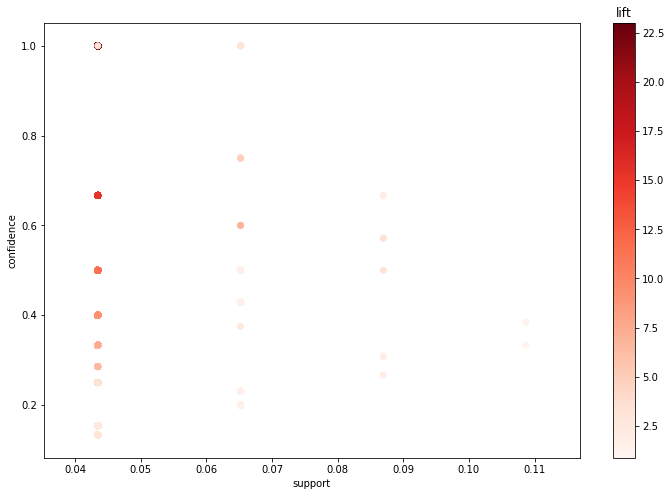

In [18]:
assoc_rules_plot(fish_rules, shading='lift')

In [19]:
fish_frequent_itemsets = apriori(df_fish_transactions, min_support=0.05, use_colnames=True)
fish_rules = association_rules(fish_frequent_itemsets, metric="confidence", min_threshold=0.6)

fish_rules.sort_values(['support', 'confidence'], ascending=False).head(50)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(vinegar),(salt),0.108696,0.326087,0.065217,0.600000,1.840000,0.029773,1.684783
4,(vinegar),(worcestershire sauce),0.108696,0.130435,0.065217,0.600000,4.600000,0.051040,2.173913
5,"(butter, salt)",(flour),0.108696,0.152174,0.065217,0.600000,3.942857,0.048677,2.119565
12,(vinegar),(cornstarch),0.108696,0.086957,0.065217,0.600000,6.900000,0.055766,2.282609
0,(cornstarch),(salt),0.086957,0.326087,0.065217,0.750000,2.300000,0.036862,2.695652
1,(parsley),(flour),0.086957,0.152174,0.065217,0.750000,4.928571,0.051985,3.391304
6,"(butter, flour)",(salt),0.086957,0.326087,0.065217,0.750000,2.300000,0.036862,2.695652
11,(cornstarch),(vinegar),0.086957,0.108696,0.065217,0.750000,6.900000,0.055766,3.565217
13,(white wine),(butter),0.086957,0.282609,0.065217,0.750000,2.653846,0.040643,2.869565
3,(fish stock),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf
